In [2]:
import requests, pandas as pd, os, sqlalchemy, sqlite3, sys, duckdb
from io import BytesIO
from sqlalchemy import create_engine
ddb     = duckdb.connect('D:/Bankit.duckdb')

In [6]:
ddb.close()

In [3]:
abr = ['ITF11', 'ITF12', 'ITF13', 'ITF14', 'ITF1']
mol = ['ITF22', 'ITF21',  'ITF2']
cam = ['ITF31', 'ITF32', 'ITF33', 'ITF34', 'ITF35', 'ITF3']
pug = ['ITF41', 'ITF42', 'ITF43', 'ITF44', 'ITF45', 'ITF4']
bas = ['ITF51', 'ITF52', 'ITF5']
cal = ['ITF65','ITF63','ITF61', 'ITF62', 'ITF64', 'ITF6']
sic = ['ITG11', 'ITG12', 'ITG13', 'ITG14', 'ITG15', 'ITG16', 'ITG17', 'ITG18', 'ITG19', 'ITG1']
sar = ['ITG21', 'ITG22', 'ITG23', 'ITG24', 'ITG2']
mezzogiorno = ['ITF1', 'ITF2', 'ITF3', 'ITF4', 'ITF5', 'ITF6', 'ITG1', 'ITG2']
ita = ['ITC', 'ITH','ITI','ITF', 'ITG', 'ITD']

In [13]:
tabella = 'TDB10224'
TDB10224 = ddb.execute(f"SELECT 'TDB10224' tabella,* FROM {tabella} WHERE LOC_CTP = 'ITF1' ORDER BY DATA_OSS").fetchdf()
TDB10224


,tabella,ATECO_CTP,DATA_OSS,ENTE_SEGN,FENEC,LOC_CTP,SET_CTP,VALORE,STATUS
0,TDB10224,F,2010-06-30,1100010,52000139,ITF1,SBI25,3003474.0,NaN
1,TDB10224,1005003,2010-06-30,1100010,52000139,ITF1,SBI25,5346268.0,NaN
2,TDB10224,1004999,2010-06-30,1100010,52000139,ITF1,SBI25,14117643.0,NaN
3,TDB10224,1005009,2010-06-30,1100010,52000139,ITF1,SBI42,22405220.0,NaN
4,TDB10224,1005001,2010-06-30,1100010,52000139,ITF1,SBI25,5214962.0,NaN
...,...,...,...,...,...,...,...,...,...
875,TDB10224,F,2025-01-31,1070001,52000139,ITF1,SBI25,1216447.0,NaN
876,TDB10224,1005001,2025-01-31,1070001,52000139,ITF1,SBI25,3162282.0,NaN
877,TDB10224,1004999,2025-01-31,1070001,52000139,ITF1,SBI25,9011058.0,NaN
878,TDB10224,1005003,2025-01-31,1070001,52000139,ITF1,SBI25,4088648.0,NaN


In [14]:
# Filtra solo la tabella TDB10224
df_10224 = TDB10224

# Assicura che DATA_OSS sia datetime
# df_10224['DATA_OSS'] = pd.to_datetime(df_10224['DATA_OSS'])

# Crea dizionario: (tabella, SET_CTP, ATECO_CTP) → lista di (DATA_OSS, VALORE)
liste_per_combinazione = {}

for (setctp, ateco), gruppo in df_10224.groupby(['SET_CTP', 'ATECO_CTP']):
    tabella = gruppo['tabella'].iloc[0]
    chiave = (tabella, setctp, ateco)
    valori = list(gruppo.sort_values('DATA_OSS')[['DATA_OSS', 'VALORE']].itertuples(index=False, name=None))
    liste_per_combinazione[chiave] = valori

# Esempio di anteprima
for chiave in list(liste_per_combinazione.keys())[:13]:
    print(f"\n{chiave}:")
    print(liste_per_combinazione[chiave][:13])


('TDB10224', 'SBI25', '1004999'):
[(Timestamp('2010-06-30 00:00:00'), 14117643.0), (Timestamp('2010-07-31 00:00:00'), 14039030.0), (Timestamp('2010-08-31 00:00:00'), 13935524.0), (Timestamp('2010-09-30 00:00:00'), 14185919.0), (Timestamp('2010-10-31 00:00:00'), 13795930.0), (Timestamp('2010-11-30 00:00:00'), 14118351.0), (Timestamp('2010-12-31 00:00:00'), 14225274.0), (Timestamp('2011-01-31 00:00:00'), 14247163.0), (Timestamp('2011-02-28 00:00:00'), 14400842.0), (Timestamp('2011-03-31 00:00:00'), 14373762.0), (Timestamp('2011-04-30 00:00:00'), 14235665.0), (Timestamp('2011-05-31 00:00:00'), 14595754.0), (Timestamp('2011-06-30 00:00:00'), 14564028.0)]

('TDB10224', 'SBI25', '1005001'):
[(Timestamp('2010-06-30 00:00:00'), 5214962.0), (Timestamp('2010-07-31 00:00:00'), 5079554.0), (Timestamp('2010-08-31 00:00:00'), 4962132.0), (Timestamp('2010-09-30 00:00:00'), 4777513.0), (Timestamp('2010-10-31 00:00:00'), 4491192.0), (Timestamp('2010-11-30 00:00:00'), 4663907.0), (Timestamp('2010-12-31

c:\Users\PVolterr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\PVolterr\AppData\Local\Temp\ipykernel_10900\2587022633.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


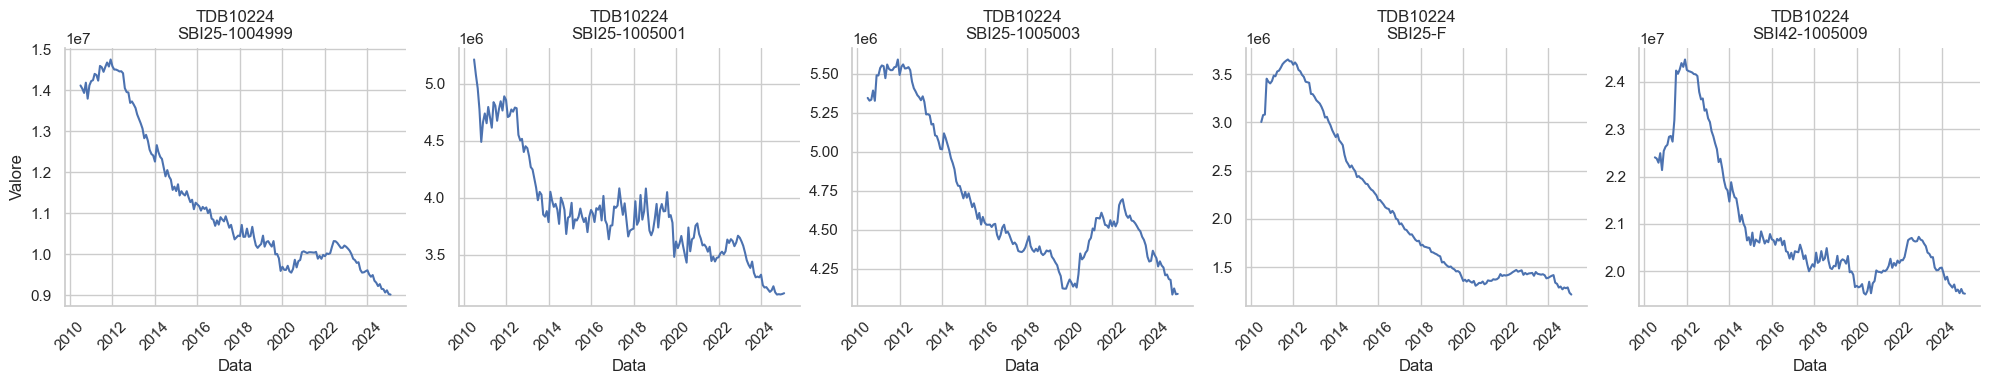

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ricrea il DataFrame da liste_per_combinazione aggiornato
dati_facet = []
for (tabella, setctp, ateco), lista in liste_per_combinazione.items():
    for data, valore in lista:
        dati_facet.append({
            'DATA_OSS': data,
            'VALORE': valore,
            'TABELLA': tabella,
            'SET_CTP': setctp,
            'ATECO_CTP': str(ateco),
            'label': f'{tabella}\n{setctp}-{ateco}'
        })

df_facet = pd.DataFrame(dati_facet)

'''
# (Opzionale) Filtra per un numero limitato di combinazioni da visualizzare
top_labels = df_facet['label'].value_counts().head(6).index  # le 6 più frequenti
df_facet = df_facet[df_facet['label'].isin(top_labels)]
'''
# Seaborn settings
sns.set(style="whitegrid")

# Crea il facet plot
g = sns.FacetGrid(df_facet, col="label", col_wrap=6, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="DATA_OSS", y="VALORE") # , marker="o"

# Personalizzazione
g.set_titles("{col_name}")
g.set_axis_labels("Data", "Valore")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()


## Tabella TDB10226

In [15]:
tabella = 'TDB10226'
TDB10226 = ddb.execute(f"SELECT 'TDB10226' tabella,* FROM {tabella} WHERE LOC_CTP = 'ITF11' ORDER BY DATA_OSS").fetchdf()
TDB10226

,tabella,DATA_OSS,ENTE_SEGN,FENEC,LOC_CTP,SET_CTP,VALORE,STATUS
0,TDB10226,2007-12-31,1100010,52000139,ITF11,SBI42,3162661.0,NaN
1,TDB10226,2007-12-31,1100010,52000139,ITF11,SBI25,1772792.0,NaN
2,TDB10226,2007-12-31,1100010,52000139,ITF11,SBI33,627272.0,NaN
3,TDB10226,2007-12-31,1100010,52000139,ITF11,S11BI13,1145519.0,NaN
4,TDB10226,2007-12-31,1100010,52000139,ITF11,SBI28,1326350.0,NaN
...,...,...,...,...,...,...,...,...
1025,TDB10226,2025-01-31,1070001,52000139,ITF11,SBI25,1352009.0,NaN
1026,TDB10226,2025-01-31,1070001,52000139,ITF11,SBI33,404400.0,NaN
1027,TDB10226,2025-01-31,1070001,52000139,ITF11,S11BI13,947610.0,NaN
1028,TDB10226,2025-01-31,1070001,52000139,ITF11,SBI42,3481051.0,NaN


In [16]:
TDB10226['SET_CTP'].unique()

array(['SBI42', 'SBI25', 'SBI33', 'S11BI13', 'SBI28'], dtype=object)

In [17]:
df_10226 = TDB10226
df_10226['DATA_OSS'] = pd.to_datetime(df_10226['DATA_OSS'])

liste_per_combinazione = {}
for setctp, gruppo in df_10226.groupby('SET_CTP'):
    tabella = gruppo['tabella'].iloc[0]
    chiave = (tabella, setctp)
    valori = list(gruppo.sort_values('DATA_OSS')[['DATA_OSS', 'VALORE']].itertuples(index=False, name=None))
    liste_per_combinazione[chiave] = valori

# Anteprima
for chiave in list(liste_per_combinazione.keys())[:13]:
    print(f"\n{chiave}:")
    print(liste_per_combinazione[chiave][:13])


('TDB10226', 'S11BI13'):
[(Timestamp('2007-12-31 00:00:00'), 1145519.0), (Timestamp('2008-01-31 00:00:00'), 1151582.0), (Timestamp('2008-02-29 00:00:00'), 1149894.0), (Timestamp('2008-03-31 00:00:00'), 1149185.0), (Timestamp('2008-04-30 00:00:00'), 1148866.0), (Timestamp('2008-05-31 00:00:00'), 1176797.0), (Timestamp('2008-06-30 00:00:00'), 1180435.0), (Timestamp('2008-07-31 00:00:00'), 1200887.0), (Timestamp('2008-08-31 00:00:00'), 1223567.0), (Timestamp('2008-09-30 00:00:00'), 1231357.0), (Timestamp('2008-10-31 00:00:00'), 1244029.0), (Timestamp('2008-11-30 00:00:00'), 1251874.0), (Timestamp('2008-12-31 00:00:00'), 1266741.0)]

('TDB10226', 'SBI25'):
[(Timestamp('2007-12-31 00:00:00'), 1772792.0), (Timestamp('2008-01-31 00:00:00'), 1807756.0), (Timestamp('2008-02-29 00:00:00'), 1809704.0), (Timestamp('2008-03-31 00:00:00'), 1812772.0), (Timestamp('2008-04-30 00:00:00'), 1819255.0), (Timestamp('2008-05-31 00:00:00'), 1848464.0), (Timestamp('2008-06-30 00:00:00'), 1838009.0), (Timesta

In [18]:
len(liste_per_combinazione)

5

In [19]:
print("Combinazioni disponibili:")
for k in liste_per_combinazione.keys():
    print(k)

Combinazioni disponibili:
('TDB10226', 'S11BI13')
('TDB10226', 'SBI25')
('TDB10226', 'SBI28')
('TDB10226', 'SBI33')
('TDB10226', 'SBI42')


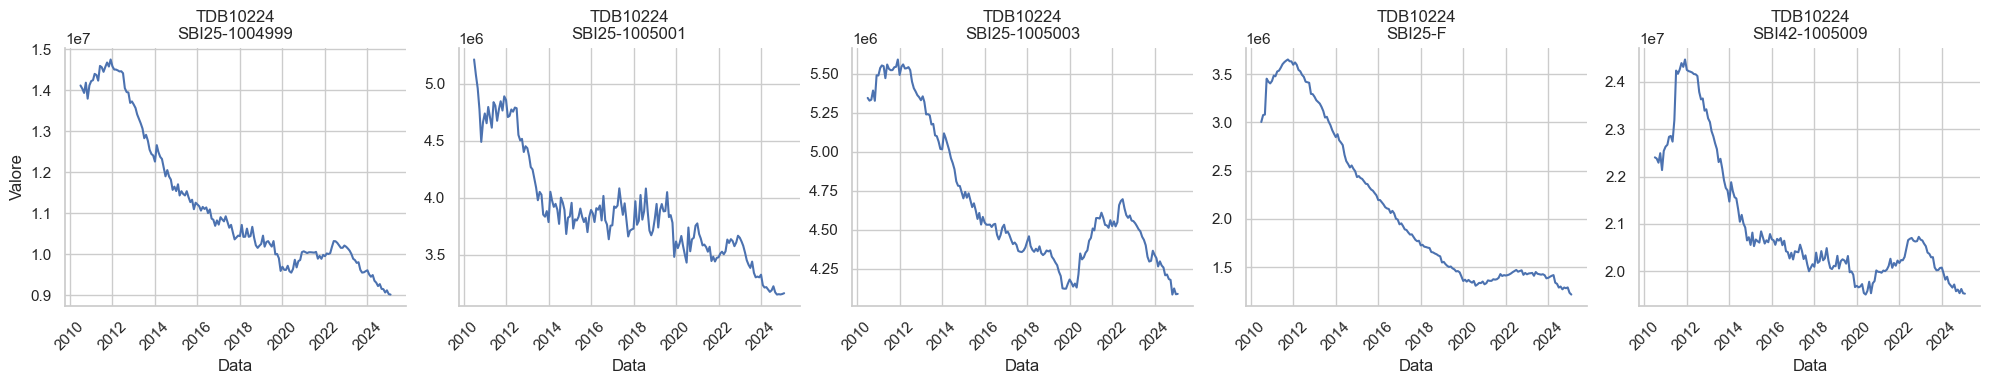

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Evita il warning sul layout
warnings.filterwarnings("ignore", message="The figure layout has changed to tight")
sns.set(style="whitegrid")

g = sns.FacetGrid(df_facet, col="label", col_wrap=6, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="DATA_OSS", y="VALORE")

g.set_titles("{col_name}")
g.set_axis_labels("Data", "Valore")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()


In [21]:
# Uno per TDB10224
df_10224 = TDB10224
df_10224['DATA_OSS'] = pd.to_datetime(df_10224['DATA_OSS'])
liste_10224 = {}
for (setctp, ateco), gruppo in df_10224.groupby(['SET_CTP', 'ATECO_CTP']):
    chiave = ('TDB10224', setctp, ateco)
    lista = list(gruppo.sort_values('DATA_OSS')[['DATA_OSS', 'VALORE']].itertuples(index=False, name=None))
    liste_10224[chiave] = lista

# Uno per TDB10226
df_10226 = TDB10226
df_10226['DATA_OSS'] = pd.to_datetime(df_10226['DATA_OSS'])
liste_10226 = {}
for setctp, gruppo in df_10226.groupby('SET_CTP'):
    chiave = ('TDB10226', setctp)
    lista = list(gruppo.sort_values('DATA_OSS')[['DATA_OSS', 'VALORE']].itertuples(index=False, name=None))
    liste_10226[chiave] = lista


In [22]:
chiave_24 = ('TDB10224', 'SBI25', '1005001')
chiave_26 = ('TDB10226', 'SBI25')

lista_24 = liste_10224[chiave_24]
lista_26 = liste_10226[chiave_26]


In [23]:
print("Chiavi disponibili in liste_10224:")
print(list(liste_10224.keys())[:5])

print("\nChiavi disponibili in liste_10226:")
print(list(liste_10226.keys())[:5])


Chiavi disponibili in liste_10224:
[('TDB10224', 'SBI25', '1004999'), ('TDB10224', 'SBI25', '1005001'), ('TDB10224', 'SBI25', '1005003'), ('TDB10224', 'SBI25', 'F'), ('TDB10224', 'SBI42', '1005009')]

Chiavi disponibili in liste_10226:
[('TDB10226', 'S11BI13'), ('TDB10226', 'SBI25'), ('TDB10226', 'SBI28'), ('TDB10226', 'SBI33'), ('TDB10226', 'SBI42')]


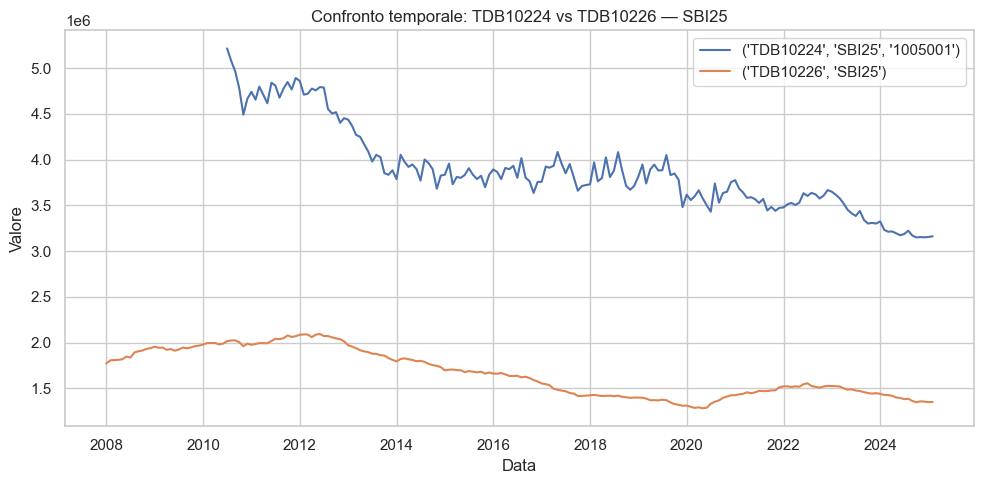

In [24]:
#Esempio completo: SBI25 da entrambe le tabelle
import matplotlib.pyplot as plt
# Scegli le chiavi da confrontare
chiave_24 = ('TDB10224', 'SBI25', '1005001')
chiave_26 = ('TDB10226', 'SBI25')

# Recupera le liste
lista_24 = liste_10224[chiave_24]
lista_26 = liste_10226[chiave_26]

# Estrai x e y
date_24, val_24 = zip(*lista_24)
date_26, val_26 = zip(*lista_26)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(date_24, val_24, label=f"{chiave_24}")
plt.plot(date_26, val_26, label=f"{chiave_26}")

plt.title("Confronto temporale: TDB10224 vs TDB10226 — SBI25")
plt.xlabel("Data")
plt.ylabel("Valore")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## funzione plot_combinazione
unzione Python che permette di plottare rapidamente una o più combinazioni da un dizionario (come liste_10224 o liste_10226) semplicemente passando il nome del dizionario e la chiave.

In [25]:
# funzione plot_combinazione()
import matplotlib.pyplot as plt

def plot_combinazione(dizionario, chiavi, titolo=None):
    """
    Plotta una o più combinazioni di (DATA_OSS, VALORE) da un dizionario.
    
    Parametri:
    - dizionario: il dizionario con chiavi come tuple (tabella, SET_CTP, ...) e valori come liste (DATA_OSS, VALORE)
    - chiavi: singola chiave o lista di chiavi da plottare
    - titolo: titolo del grafico (facoltativo)
    """
    if not isinstance(chiavi, list):
        chiavi = [chiavi]

    plt.figure(figsize=(10, 5))

    for chiave in chiavi:
        if chiave not in dizionario:
            print(f"Chiave {chiave} non trovata.")
            continue

        lista = dizionario[chiave]
        if not lista:
            continue
        date, valori = zip(*lista)
        plt.plot(date, valori, label=str(chiave))

    plt.xlabel("DATA_OSS")
    plt.ylabel("VALORE")
    plt.title(titolo or "Andamento temporale")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


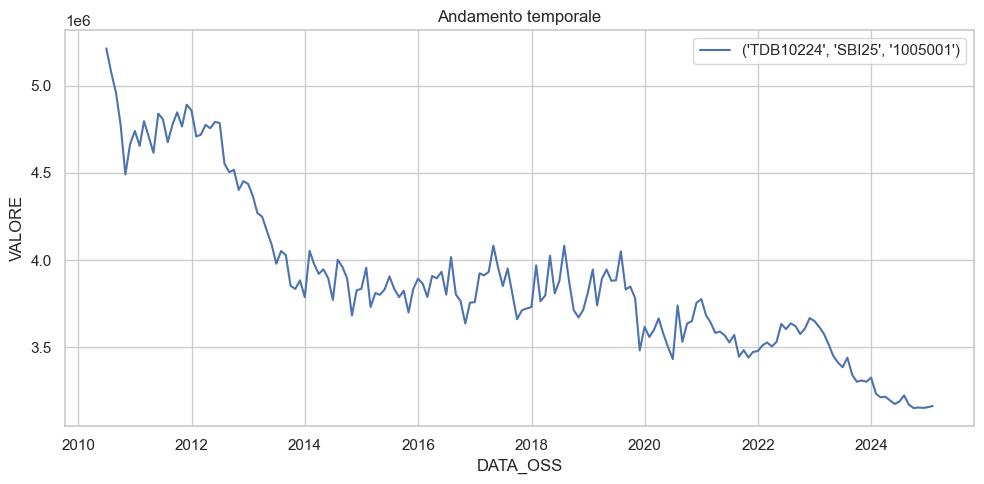

In [26]:
# 1. Una combinazione:
plot_combinazione(liste_10224, ('TDB10224', 'SBI25', '1005001'))


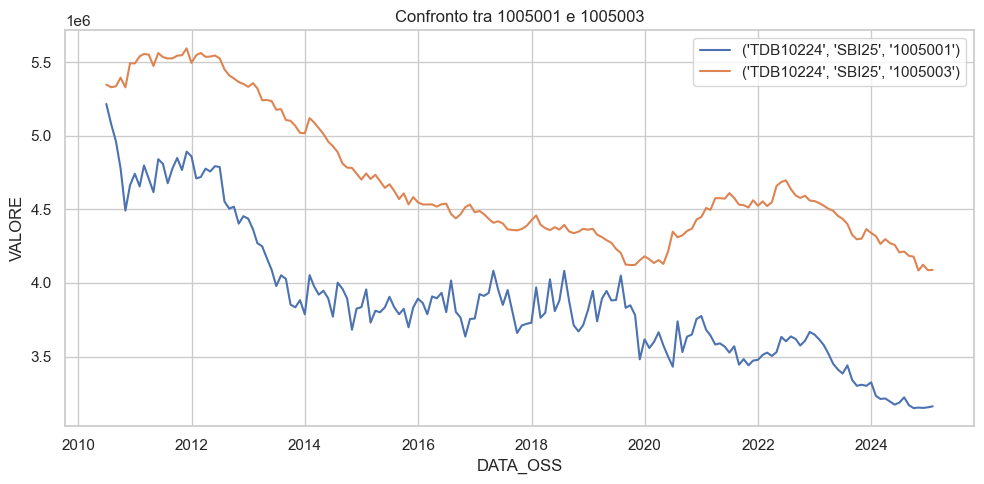

In [27]:
# Due curve a confronto:
plot_combinazione(
    dizionario=liste_10224,
    chiavi=[
        ('TDB10224', 'SBI25', '1005001'),
        ('TDB10224', 'SBI25', '1005003')
    ],
    titolo="Confronto tra 1005001 e 1005003"
)


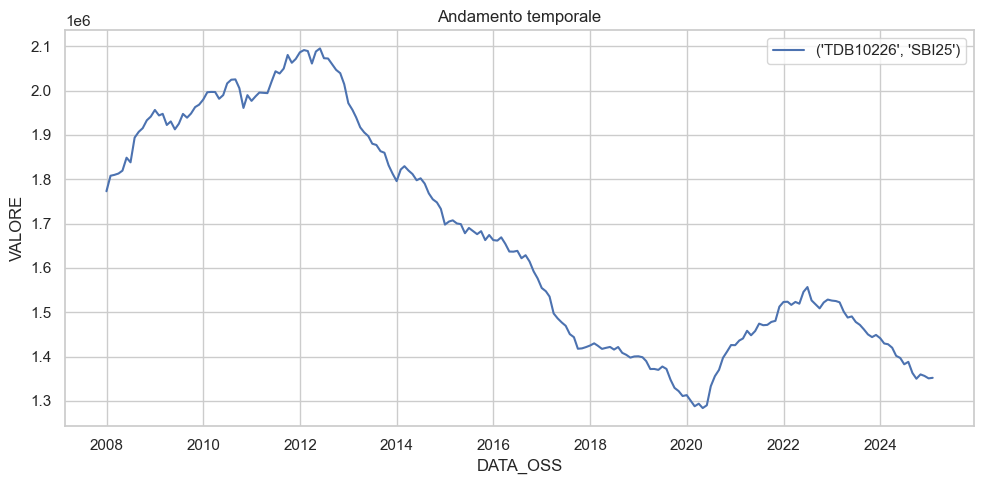

In [28]:
plot_combinazione(liste_10226, ('TDB10226', 'SBI25'))


## definire tutti dizionari possibili con le tabelle che invece avevamo accorpato in un jnico dataframe

In [41]:
from collections import defaultdict

# Dizionari finali per ogni tabella
liste_10224 = {}
liste_10226 = {}
liste_10281 = {}
liste_10420 = {}
liste_10430 = {}
liste_10460 = {}

# --- TDB10224 ---
df_10224 = TDB10224
for (setctp, ateco), gruppo in df_10224.groupby(['SET_CTP', 'ATECO_CTP']):
    chiave = ('TDB10224', setctp, ateco)
    lista = list(gruppo.sort_values('DATA_OSS')[['DATA_OSS', 'VALORE']].itertuples(index=False, name=None))
    liste_10224[chiave] = lista

# --- TDB10226 ---
df_10226 = TDB10226
for setctp, gruppo in df_10226.groupby('SET_CTP'):
    chiave = ('TDB10226', setctp)
    lista = list(gruppo.sort_values('DATA_OSS')[['DATA_OSS', 'VALORE']].itertuples(index=False, name=None))
    liste_10226[chiave] = lista

# --- TFR10281 ---
df_10281 = TFR10281
for (loc, setctp), gruppo in df_10281.groupby(['LOC_CTP', 'SET_CTP']):
    chiave = ('TFR10281', loc, setctp)
    lista = list(gruppo.sort_values('DATA_OSS')[['DATA_OSS', 'VALORE']].itertuples(index=False, name=None))
    liste_10281[chiave] = lista

# --- TDB10420 ---
df_10420 = TFR10420
for (desinv, tiptasso), gruppo in df_10420.groupby(['DESINV', 'TIPTASSO']):
    chiave = ('TDB10420', desinv, tiptasso)
    lista = list(gruppo.sort_values('DATA_OSS')[['DATA_OSS', 'VALORE']].itertuples(index=False, name=None))
    liste_10420[chiave] = lista

# --- TDB10430 ---
df_10430 = TFR10430
for (desinv, tiptasso), gruppo in df_10430.groupby(['DESINV', 'TIPTASSO']):
    chiave = ('TDB10430', desinv, tiptasso)
    lista = list(gruppo.sort_values('DATA_OSS')[['DATA_OSS', 'VALORE']].itertuples(index=False, name=None))
    liste_10430[chiave] = lista

# --- TFR10460 ---
df_10460 = TFR10460
for (desinv, tiptasso), gruppo in df_10460.groupby(['DESINV', 'TIPTASSO']):
    chiave = ('TFR10460', desinv, tiptasso)
    lista = list(gruppo.sort_values('DATA_OSS')[['DATA_OSS', 'VALORE']].itertuples(index=False, name=None))
    liste_10460[chiave] = lista


In [36]:
tabella = 'TFR10281'
TFR10281 = ddb.execute(f"SELECT 'TFR10281' tabella,* FROM {tabella}  where LOC_CTP = 'ITF11' ORDER BY DATA_OSS").fetchdf()
TFR10281

,tabella,DATA_OSS,DESINV,ENTE_SEGN,FENEC,LOC_CTP,SET_CTP,VALORE,STATUS


In [ ]:
tabella = 'TFR10281'
TFR10281 = ddb.execute(f"SELECT 'TFR10281' tabella,* FROM {tabella}  where LOC_CTP = 'ITF11' ORDER BY DATA_OSS").fetchdf()
TFR10281

,tabella,DATA_OSS,DESINV,ENTE_SEGN,FENEC,LOC_CTP,SET_CTP,VALORE,STATUS


In [40]:
tabella = 'TFR10420'
TFR10420 = ddb.execute(f"SELECT 'TFR10420' tabella,* FROM {tabella} where LOC_CTP = 'ITF11' ORDER BY DATA_OSS").fetchdf() #  
TFR10420

,tabella,DATA_OSS,DESINV,DURORI,ENTE_SEGN,FENEC,LOC_CTP,RESIDENZA1,TIPTASSO,VALORE,STATUS
0,TFR10420,2008-12-31,10,18,1100010,1001530,ITF11,IT,800,316625.0,NaN
1,TFR10420,2008-12-31,110,18,1100010,1001530,ITF11,IT,10000,158364.0,NaN
2,TFR10420,2008-12-31,905,18,1100010,1001530,ITF11,IT,800,170625.0,NaN
3,TFR10420,2008-12-31,998,18,1100010,1001530,ITF11,IT,10000,817922.0,NaN
4,TFR10420,2008-12-31,10,18,1100010,1001530,ITF11,IT,10000,319095.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2588,TFR10420,2024-09-30,110,18,1070001,1001530,ITF11,IT,800,244890.0,NaN
2589,TFR10420,2024-09-30,909,18,1070001,1001530,ITF11,IT,10000,60555.0,NaN
2590,TFR10420,2024-09-30,912,18,1070001,1001530,ITF11,IT,80,340.0,NaN
2591,TFR10420,2024-09-30,998,18,1070001,1001530,ITF11,IT,800,1319977.0,NaN


In [33]:
tabella = 'TFR10430'
TFR10430 = ddb.execute(f"SELECT 'TDB10430' tabella,* FROM {tabella}  where LOC_CTP = 'ITF11' ORDER BY DATA_OSS").fetchdf()
TFR10430

,tabella,DATA_OSS,DESINV,DURORI,ENTE_SEGN,FENEC,LOC_CTP,RESIDENZA1,TIPTASSO,VALORE,STATUS
0,TDB10430,2008-12-31,80,18,1100010,1001531,ITF11,IT,800,753.0,NaN
1,TDB10430,2008-12-31,120,18,1100010,1001531,ITF11,IT,800,3572.0,NaN
2,TDB10430,2008-12-31,10,18,1100010,1001531,ITF11,IT,80,89.0,NaN
3,TDB10430,2008-12-31,40,18,1100010,1001531,ITF11,IT,800,500.0,NaN
4,TDB10430,2008-12-31,912,18,1100010,1001531,ITF11,IT,800,16283.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2161,TDB10430,2024-09-30,80,18,1070001,1001531,ITF11,IT,10000,2880.0,NaN
2162,TDB10430,2024-09-30,902,18,1070001,1001531,ITF11,IT,10000,2656.0,NaN
2163,TDB10430,2024-09-30,914,18,1070001,1001531,ITF11,IT,80,1069.0,NaN
2164,TDB10430,2024-09-30,110,18,1070001,1001531,ITF11,IT,800,20823.0,NaN


In [34]:
tabella = 'TFR10460'
TFR10460 = ddb.execute(f"SELECT 'TFR10460' tabella,* FROM {tabella} where LOC_CTP = 'ITF11'ORDER BY DATA_OSS").fetchdf()
TFR10460

,tabella,DATA_OSS,DESINV,DURORI,ENTE_SEGN,FENEC,LOC_CTP,RESIDENZA1,TIPTASSO,VALORE,STATUS
0,TFR10460,2008-12-31,90,18,1100010,1001530,ITF11,IT,10000,6785.0,NaN
1,TFR10460,2008-12-31,20,18,1100010,1001530,ITF11,IT,10000,15951.0,NaN
2,TFR10460,2008-12-31,996,18,1100010,1001530,ITF11,IT,80,2110.0,NaN
3,TFR10460,2008-12-31,50,18,1100010,1001530,ITF11,IT,10000,13062.0,NaN
4,TFR10460,2008-12-31,20,18,1100010,1001530,ITF11,IT,800,15560.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
682,TFR10460,2024-09-30,90,18,1070001,1001530,ITF11,IT,800,2603.0,NaN
683,TFR10460,2024-09-30,90,18,1070001,1001530,ITF11,IT,10000,2603.0,NaN
684,TFR10460,2024-09-30,20,18,1070001,1001530,ITF11,IT,10000,4461.0,NaN
685,TFR10460,2024-09-30,20,18,1070001,1001530,ITF11,IT,800,4461.0,NaN


In [131]:
tabella = 'TDB10224'
TDB10224 = ddb.execute(f"SELECT '{tabella}' AS tabella, * FROM {tabella} ORDER BY DATA_OSS").fetchdf()

tabella = 'TDB10226'
TDB10226 = ddb.execute(f"SELECT '{tabella}' AS tabella, * FROM {tabella} ORDER BY DATA_OSS").fetchdf()

tabella = 'TFR10281'
TFR10281 = ddb.execute(f"SELECT '{tabella}' AS tabella, * FROM {tabella} ORDER BY DATA_OSS").fetchdf()

tabella = 'TFR10420'
TFR10420 = ddb.execute(f"SELECT '{tabella}' AS tabella, * FROM {tabella} ORDER BY DATA_OSS").fetchdf()

tabella = 'TFR10430'
TFR10430 = ddb.execute(f"SELECT '{tabella}' AS tabella, * FROM {tabella} ORDER BY DATA_OSS").fetchdf()

tabella = 'TFR10460'
TFR10460 = ddb.execute(f"SELECT '{tabella}' AS tabella, * FROM {tabella} ORDER BY DATA_OSS").fetchdf()


In [132]:
# Lista delle tabelle Bankitalia da caricare
tabelle_nomi = ['TDB10224', 'TDB10226', 'TFR10281', 'TFR10420', 'TFR10430', 'TFR10460']

# Caricamento da DuckDB
dati = {}
for tabella in tabelle_nomi:
    query = f"SELECT '{tabella}' AS tabella, * FROM {tabella} ORDER BY DATA_OSS"
    dati[tabella] = ddb.execute(query).fetchdf()


In [133]:
def crea_dizionario_auto(df, tabella):
    import pandas as pd
    from collections import defaultdict

    df = df.copy()
    df['DATA_OSS'] = pd.to_datetime(df['DATA_OSS'])
    df = df.dropna(subset=['DATA_OSS', 'VALORE'])

    colonne_candidati = ['LOC_CTP', 'SET_CTP', 'ATECO_CTP', 'DESINV', 'TIPTASSO']
    colonne_presenti = [col for col in colonne_candidati if col in df.columns]

    for n in range(len(colonne_presenti), 0, -1):
        from itertools import combinations
        for comb in combinations(colonne_presenti, n):
            subset = df[list(comb)].dropna()
            if not subset.empty:
                df = df.dropna(subset=list(comb))
                chiavi_groupby = list(comb)
                break
        else:
            continue
        break
    else:
        print(f"⚠️ Nessuna combinazione valida per {tabella}")
        return {}

    dizionario = {}
    for chiave_raw, gruppo in df.groupby(chiavi_groupby):
        chiave = (tabella, *chiave_raw) if isinstance(chiave_raw, tuple) else (tabella, chiave_raw)
        valori = list(gruppo.sort_values('DATA_OSS')[['DATA_OSS', 'VALORE']].itertuples(index=False, name=None))
        dizionario[chiave] = valori

    print(f"✅ {len(dizionario)} combinazioni generate da {tabella} con: {chiavi_groupby}")
    return dizionario


In [134]:
dizionari = {}

for tabella in tabelle_nomi:
    df = dati[tabella]
    dizionari[tabella] = crea_dizionario_auto(df, tabella)


✅ 705 combinazioni generate da TDB10224 con: ['LOC_CTP', 'SET_CTP', 'ATECO_CTP']
✅ 705 combinazioni generate da TDB10226 con: ['LOC_CTP', 'SET_CTP']
✅ 72 combinazioni generate da TFR10281 con: ['LOC_CTP', 'SET_CTP', 'DESINV']
✅ 5821 combinazioni generate da TFR10420 con: ['LOC_CTP', 'DESINV', 'TIPTASSO']
✅ 5723 combinazioni generate da TFR10430 con: ['LOC_CTP', 'DESINV', 'TIPTASSO']
✅ 1674 combinazioni generate da TFR10460 con: ['LOC_CTP', 'DESINV', 'TIPTASSO']


In [139]:
def plot_combinazione(
    dizionario,
    chiavi,
    titolo=None,
    normalizza=False,
    salva=None
):
    """
    Plotta una o più serie temporali contenute in un dizionario di liste.

    Args:
        dizionario: dict del tipo { (tabella, ...): [(DATA_OSS, VALORE), ...] }
        chiavi: singola chiave o lista di chiavi da plottare
        titolo: stringa opzionale per il titolo del grafico
        normalizza: True per normalizzare ogni serie a base 100
        salva: path opzionale per salvare il grafico come immagine
    """
    import matplotlib.pyplot as plt

    if not isinstance(chiavi, list):
        chiavi = [chiavi]

    plt.figure(figsize=(10, 5))

    almeno_una = False

    for chiave in chiavi:
        if chiave not in dizionario:
            print(f"⚠️ Chiave non trovata: {chiave}")
            continue

        data_valori = dizionario[chiave]
        if not data_valori:
            continue

        date, valori = zip(*sorted(data_valori))

        if normalizza and valori[0] != 0:
            valori = [(v / valori[0]) * 100 for v in valori]

        plt.plot(date, valori,  label=' - '.join(map(str, chiave)))
        almeno_una = True

    if not almeno_una:
        print("❌ Nessuna curva valida da tracciare.")
        return

    plt.xlabel("DATA_OSS")
    plt.ylabel("VALORE normalizzato" if normalizza else "VALORE")
    plt.title(titolo or "Serie temporali")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if salva:
        plt.savefig(salva, dpi=300)
        print(f"✅ Grafico salvato in: {salva}")
    else:
        plt.show()


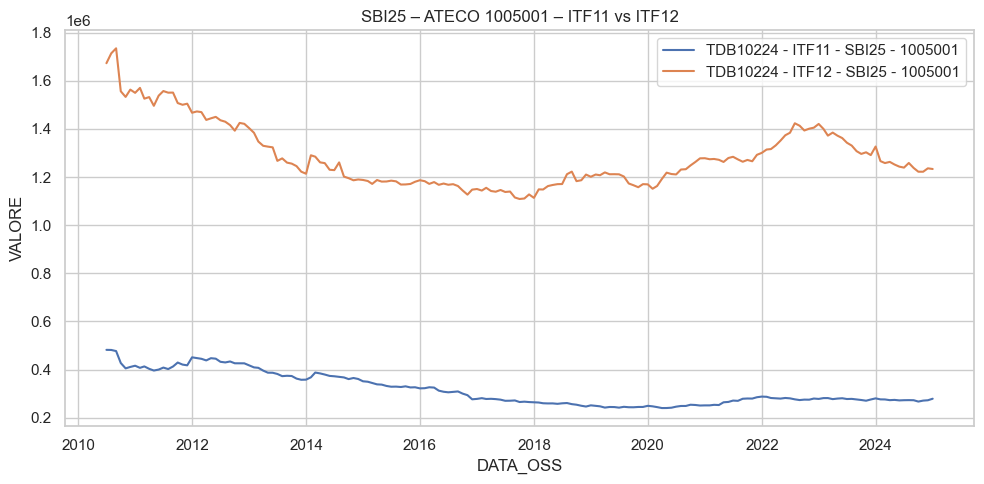

In [140]:
plot_combinazione(
    dizionari['TDB10224'],
    [
        ('TDB10224', 'ITF11', 'SBI25', '1005001'),
        ('TDB10224', 'ITF12', 'SBI25', '1005001')
    ],
    titolo="SBI25 – ATECO 1005001 – ITF11 vs ITF12",
    normalizza=False
)


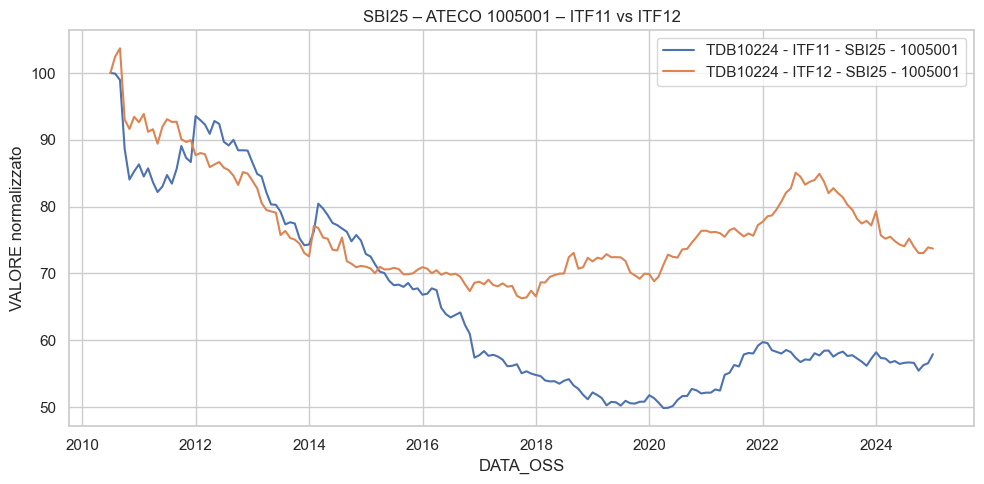

In [141]:
plot_combinazione(
    dizionari['TDB10224'],
    [
        ('TDB10224', 'ITF11', 'SBI25', '1005001'),
        ('TDB10224', 'ITF12', 'SBI25', '1005001')
    ],
    titolo="SBI25 – ATECO 1005001 – ITF11 vs ITF12",
    normalizza=True
)


In [144]:
def grafico_confronto_nuts(
    dizionari: dict,
    tabelle: list,
    nuts: list,
    set_ctp: str,
    ateco_ctp: str = None,
    normalizza=False,
    titolo=None
):
    """
    Confronta nel tempo il VALORE per una combinazione SET_CTP (+ ATECO_CTP opzionale)
    su più tabelle e NUTS (LOC_CTP), aggregando i valori se necessario.

    Args:
        dizionari: dict con le strutture {tabella: dizionario delle combinazioni}
        tabelle: lista di nomi tabella da confrontare (es. ['TDB10224', 'TDB10226'])
        nuts: lista di LOC_CTP da filtrare (es. ['ITF11', 'ITF12'])
        set_ctp: codice SET_CTP da confrontare (es. 'SBI25')
        ateco_ctp: opzionale, usato per tabelle che hanno anche ATECO_CTP
        normalizza: se True, porta la serie a base 100
        titolo: titolo del grafico
    """
    import matplotlib.pyplot as plt
    from collections import defaultdict

    plt.figure(figsize=(10, 5))
    almeno_una = False

    for tabella in tabelle:
        diz = dizionari.get(tabella, {})
        serie = defaultdict(float)

        for chiave, lista in diz.items():
            if chiave[0] != tabella:
                continue

            # TDB10224: ('TDB10224', LOC_CTP, SET_CTP, ATECO_CTP)
            if tabella == 'TDB10224':
                if len(chiave) == 4:
                    _, loc, sbi, ateco = chiave
                    if loc in nuts and sbi == set_ctp and (ateco_ctp is None or ateco == ateco_ctp):
                        for data, valore in lista:
                            serie[data] += valore

            # TDB10226: ('TDB10226', LOC_CTP, SET_CTP)
            elif tabella == 'TDB10226':
                if len(chiave) == 3:
                    _, loc, sbi = chiave
                    if loc in nuts and sbi == set_ctp:
                        for data, valore in lista:
                            serie[data] += valore

            # Puoi estendere per altre tabelle come TFR10281, TFR10420, ecc.

        if not serie:
            print(f"⚠️ Nessun dato trovato per {tabella} – {set_ctp} – {ateco_ctp} – {nuts}")
            continue

        almeno_una = True
        serie_ordinata = sorted(serie.items())
        date, valori = zip(*serie_ordinata)
        if normalizza and valori[0] != 0:
            valori = [(v / valori[0]) * 100 for v in valori]

        label = f"{tabella} - {set_ctp}"
        if ateco_ctp:
            label += f" - {ateco_ctp}"
        if nuts:
            label += f" ({'+'.join(nuts)})"

        plt.plot(date, valori, label=label)

    if not almeno_una:
        print("❌ Nessuna curva valida trovata.")
        return

    plt.title(titolo or f"Confronto {set_ctp}" + (f" - {ateco_ctp}" if ateco_ctp else ""))
    plt.xlabel("DATA_OSS")
    plt.ylabel("VALORE normalizzato" if normalizza else "VALORE")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


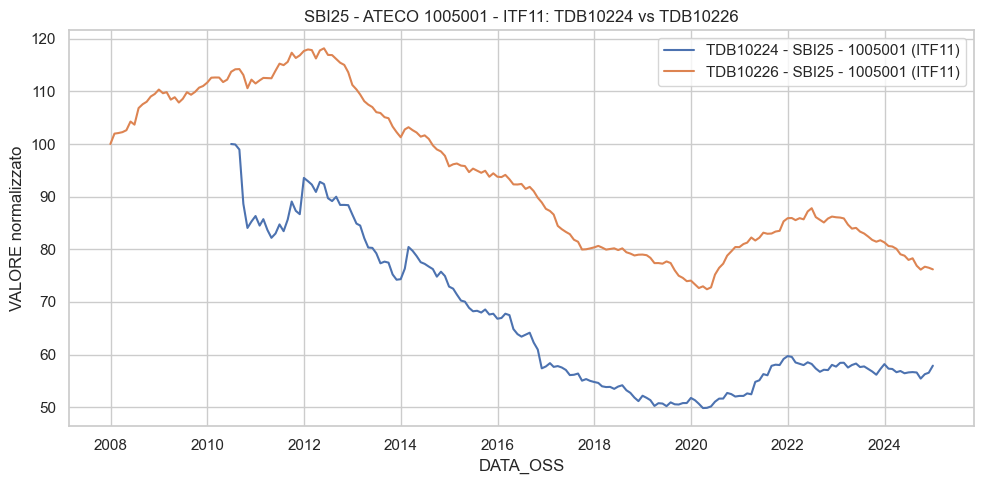

In [145]:
grafico_confronto_nuts(
    dizionari=dizionari,
    tabelle=['TDB10224', 'TDB10226'],
    nuts=['ITF11'],
    set_ctp='SBI25',
    ateco_ctp='1005001',
    normalizza=True,
    titolo="SBI25 - ATECO 1005001 - ITF11: TDB10224 vs TDB10226"
)


In [148]:
def grafico_confronto_nuts_dinamico(
    dizionari: dict,
    tabelle: list,
    nuts: list = None,
    set_ctp: str = None,
    ateco_ctp: str = None,
    normalizza=False,
    titolo=None
):
    """
    Confronta serie temporali da uno o più dizionari dinamicamente, filtrando per LOC_CTP, SET_CTP, ATECO_CTP.

    Args:
        dizionari: dizionario delle tabelle, ciascuna contenente combinazioni: {(tabella, ...): [(DATA_OSS, VALORE), ...]}
        tabelle: lista di tabelle da confrontare (es. ['TDB10224', 'TDB10226'])
        nuts: lista di LOC_CTP da includere (es. ['ITF11'])
        set_ctp: filtro su SET_CTP (es. 'SBI25')
        ateco_ctp: filtro su ATECO_CTP (opzionale)
        normalizza: se True, normalizza ogni curva a base 100
        titolo: titolo del grafico
    """
    import matplotlib.pyplot as plt
    from collections import defaultdict

    plt.figure(figsize=(10, 5))
    almeno_una = False

    for tabella in tabelle:
        diz = dizionari.get(tabella, {})
        serie = defaultdict(float)

        for chiave, lista in diz.items():
            if chiave[0] != tabella:
                continue

            chiave_dict = { 'tabella': chiave[0] }
            chiave_labels = []

            # Costruzione dinamica chiave_dict (basata su posizioni e contenuti)
            for k in chiave[1:]:
                if isinstance(k, str) and k.startswith("IT"):  # es. 'ITF11'
                    chiave_dict['LOC_CTP'] = k
                elif isinstance(k, str) and k.startswith("SBI"):
                    chiave_dict['SET_CTP'] = k
                elif isinstance(k, str) and k.isalpha():
                    chiave_dict.setdefault('SET_CTP_ALT', k)
                elif isinstance(k, str) and k.isalnum():
                    chiave_dict['ATECO_CTP'] = k
                elif isinstance(k, (int, float)):
                    chiave_dict.setdefault('DESINV', k)
                chiave_labels.append(str(k))

            # Applica i filtri dinamicamente
            if nuts and chiave_dict.get('LOC_CTP') not in nuts:
                continue
            if set_ctp and chiave_dict.get('SET_CTP') != set_ctp:
                continue
            if ateco_ctp and chiave_dict.get('ATECO_CTP') != ateco_ctp:
                continue

            for data, valore in lista:
                serie[data] += valore

        if not serie:
            print(f"⚠️ Nessun dato per {tabella} – {set_ctp} – {ateco_ctp} – {nuts}")
            continue

        almeno_una = True
        serie_ordinata = sorted(serie.items())
        date, valori = zip(*serie_ordinata)
        if normalizza and valori[0] != 0:
            valori = [(v / valori[0]) * 100 for v in valori]

        label = f"{tabella}" + (f" - {set_ctp}" if set_ctp else "")
        if ateco_ctp:
            label += f" - {ateco_ctp}"
        if nuts:
            label += f" ({'+'.join(nuts)})"

        plt.plot(date, valori,  label=label)

    if not almeno_una:
        print("❌ Nessuna curva valida da tracciare.")
        return

    plt.title(titolo or "Confronto serie temporali")
    plt.xlabel("DATA_OSS")
    plt.ylabel("VALORE normalizzato" if normalizza else "VALORE")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


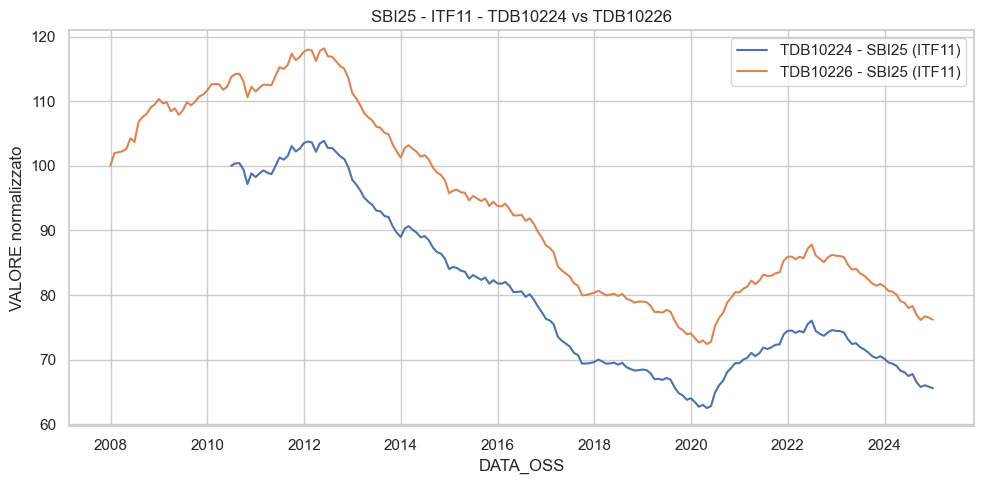

In [149]:
grafico_confronto_nuts_dinamico(
    dizionari=dizionari,
    tabelle=['TDB10224', 'TDB10226'],
    nuts=['ITF11'],
    set_ctp='SBI25',
    normalizza=True,
    titolo="SBI25 - ITF11 - TDB10224 vs TDB10226"
)


In [150]:
def grafico_confronto_nuts_pro(
    dizionari: dict,
    tabelle: list,
    filters: dict,
    normalizza=False,
    titolo=None
):
    """
    Confronta serie temporali da più tabelle, filtrando le combinazioni per valori nelle chiavi.

    Args:
        dizionari: dict con struttura {tabella: dizionario combinazioni}
        tabelle: lista di nomi tabella (es. ['TDB10224', 'TDB10226'])
        filters: dict con valori da filtrare nelle chiavi (es. {'LOC_CTP': ['ITF11'], 'SET_CTP': ['SBI25'], 'ATECO_CTP': ['1005001']})
        normalizza: True per normalizzare a base 100
        titolo: titolo del grafico
    """
    import matplotlib.pyplot as plt
    from collections import defaultdict

    plt.figure(figsize=(10, 5))
    almeno_una = False

    for tabella in tabelle:
        diz = dizionari.get(tabella, {})
        serie = defaultdict(float)

        for chiave, lista in diz.items():
            if chiave[0] != tabella:
                continue

            # Estrai i componenti della chiave (es. 'LOC_CTP', 'SET_CTP', ecc.)
            componenti = chiave[1:]
            colonne_chiave = _colonne_chiave_da_combinazione(componenti)
            chiave_dict = dict(zip(colonne_chiave, componenti))

            # Applica i filtri
            include = True
            for col, val in filters.items():
                if col in chiave_dict and (val is not None):
                    val_list = val if isinstance(val, list) else [val]
                    if chiave_dict[col] not in val_list:
                        include = False
                        break
            if not include:
                continue

            for data, valore in lista:
                serie[data] += valore

        if not serie:
            print(f"⚠️ Nessun dato per {tabella} con filtro: {filters}")
            continue

        almeno_una = True
        serie_ordinata = sorted(serie.items())
        date, valori = zip(*serie_ordinata)
        if normalizza and valori[0] != 0:
            valori = [(v / valori[0]) * 100 for v in valori]

        label_parts = [tabella]
        for col in ['LOC_CTP', 'SET_CTP', 'ATECO_CTP']:
            if col in filters:
                label_parts.append(f"{col}={'+'.join(filters[col]) if isinstance(filters[col], list) else filters[col]}")
        plt.plot(date, valori, marker='o', label=' | '.join(label_parts))

    if not almeno_una:
        print("❌ Nessuna curva valida trovata.")
        return

    plt.title(titolo or "Confronto serie temporali")
    plt.xlabel("DATA_OSS")
    plt.ylabel("VALORE normalizzato" if normalizza else "VALORE")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def _colonne_chiave_da_combinazione(componenti):
    """
    Deduci i nomi delle colonne chiave in base al numero di componenti (dopo il nome tabella).
    Serve per assegnare 'LOC_CTP', 'SET_CTP', 'ATECO_CTP', 'DESINV', 'TIPTASSO' ecc.
    """
    mapping_standard = {
        1: ['SET_CTP'],
        2: ['LOC_CTP', 'SET_CTP'],
        3: ['LOC_CTP', 'SET_CTP', 'ATECO_CTP'],
        4: ['LOC_CTP', 'DESINV', 'TIPTASSO'],
        5: ['LOC_CTP', 'SET_CTP', 'DESINV', 'TIPTASSO']
    }
    return mapping_standard.get(len(componenti), [f"VAR{i}" for i in range(1, len(componenti) + 1)])


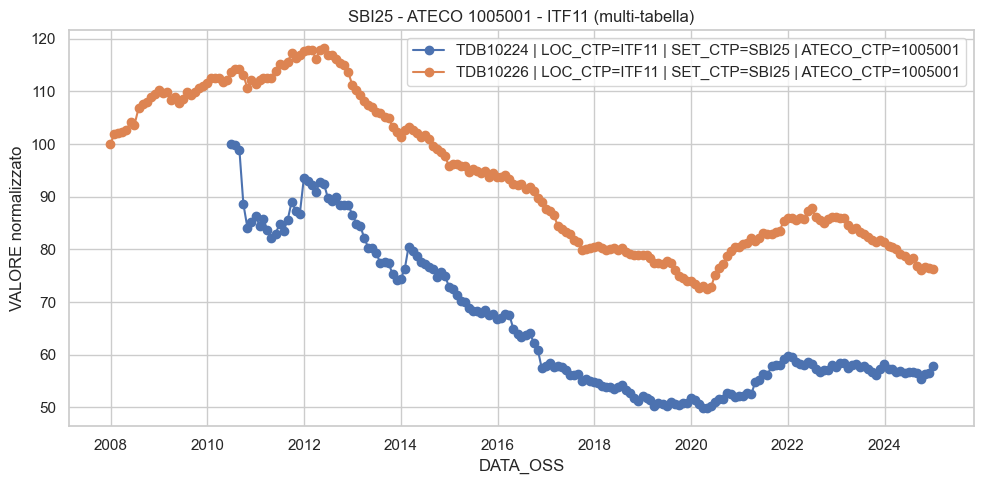

In [151]:
grafico_confronto_nuts_pro(
    dizionari=dizionari,
    tabelle=['TDB10224', 'TDB10226'],
    filters={'LOC_CTP': ['ITF11'], 'SET_CTP': ['SBI25'], 'ATECO_CTP': ['1005001']},
    normalizza=True,
    titolo="SBI25 - ATECO 1005001 - ITF11 (multi-tabella)"
)


⚠️ Nessun dato per TFR10420 con filtro: {'LOC_CTP': ['ITF11'], 'SET_CTP': ['SBI25']}


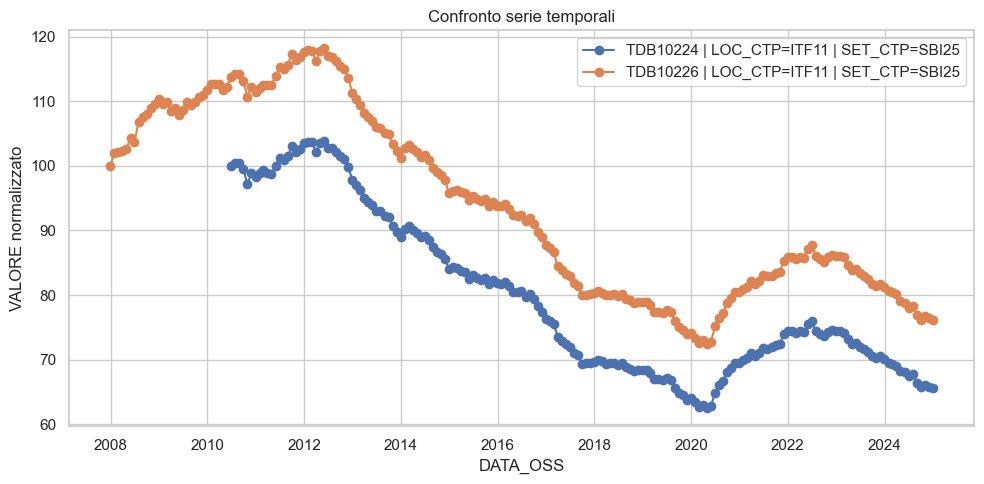

In [154]:
grafico_confronto_nuts_pro(
    dizionari=dizionari,
    tabelle=['TDB10224', 'TDB10226','TFR10420'],
    filters={'LOC_CTP': ['ITF11'], 'SET_CTP': ['SBI25']},  # niente ATECO_CTP = aggrega
    normalizza=True
)


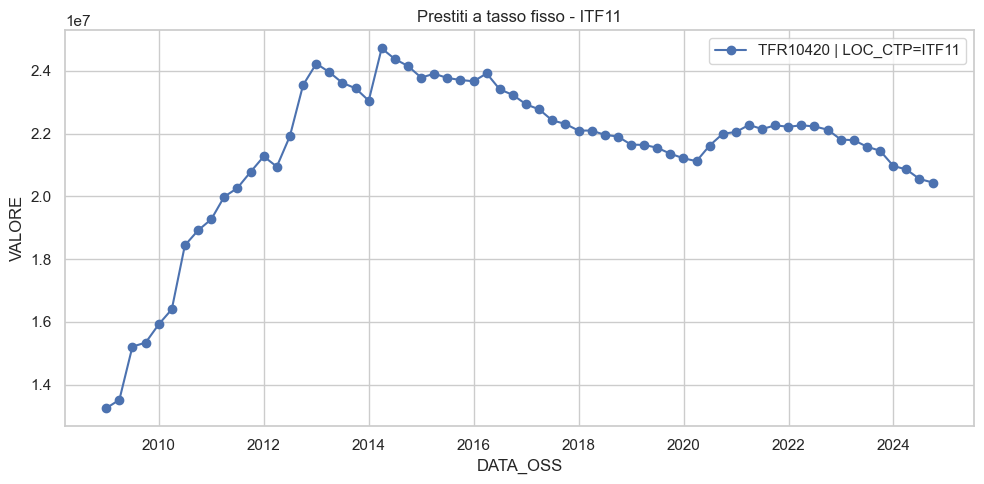

In [153]:
grafico_confronto_nuts_pro(
    dizionari=dizionari,
    tabelle=['TFR10420'],
    filters={'LOC_CTP': ['ITF11'], 'DESINV': ['110'], 'TIPTASSO': ['10000']},
    normalizza=False,
    titolo="Prestiti a tasso fisso - ITF11"
)


⚠️ Nessun dato per TFR10281 con filtro: {'LOC_CTP': ['ITF11'], 'SET_CTP': ['SBI25']}


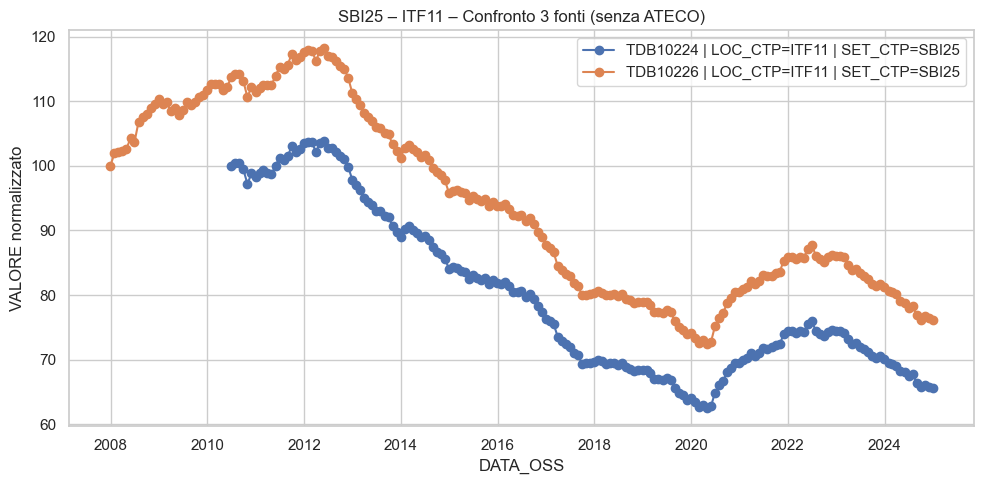

In [156]:
grafico_confronto_nuts_pro(
    dizionari=dizionari,
    tabelle=['TDB10224', 'TDB10226', 'TFR10281'],
    filters={
        'LOC_CTP': ['ITF11'],
        'SET_CTP': ['SBI25']
        # niente 'ATECO_CTP'
    },
    normalizza=True,
    titolo="SBI25 – ITF11 – Confronto 3 fonti (senza ATECO)"
)


In [157]:
TFR10281[TFR10281['LOC_CTP'] == 'ITF11']['SET_CTP'].dropna().unique()


array([], dtype=object)

In [158]:
TFR10281[TFR10281['SET_CTP'] == 'SBI25']['LOC_CTP'].dropna().unique()


array([], dtype=object)

In [161]:
def trova_combinazioni_per_nuts(dizionari, nuts_code):
    """
    Restituisce tutte le chiavi che contengono il valore NUTS specificato (es. 'ITF11').

    Args:
        dizionari: dict globale {tabella: dizionario_combinazioni}
        nuts_code: codice NUTS da cercare (es. 'ITF11')

    Returns:
        dict: {tabella: [chiavi che contengono il NUTS]}
    """
    risultati = {}

    for tabella, diz in dizionari.items():
        chiavi_match = [k for k in diz if nuts_code in k]
        if chiavi_match:
            risultati[tabella] = chiavi_match

    return risultati


In [162]:
combinazioni_itf11 = trova_combinazioni_per_nuts(dizionari, 'ITF11')

for tab, chiavi in combinazioni_itf11.items():
    print(f"\n📊 {tab} – {len(chiavi)} combinazioni trovate:")
    for k in chiavi[:5]:  # mostra solo le prime 5 per tabella
        print("  ", k)



📊 TDB10224 – 5 combinazioni trovate:
   ('TDB10224', 'ITF11', 'SBI25', '1004999')
   ('TDB10224', 'ITF11', 'SBI25', '1005001')
   ('TDB10224', 'ITF11', 'SBI25', '1005003')
   ('TDB10224', 'ITF11', 'SBI25', 'F')
   ('TDB10224', 'ITF11', 'SBI42', '1005009')

📊 TDB10226 – 5 combinazioni trovate:
   ('TDB10226', 'ITF11', 'S11BI13')
   ('TDB10226', 'ITF11', 'SBI25')
   ('TDB10226', 'ITF11', 'SBI28')
   ('TDB10226', 'ITF11', 'SBI33')
   ('TDB10226', 'ITF11', 'SBI42')

📊 TFR10420 – 41 combinazioni trovate:
   ('TFR10420', 'ITF11', 10, 80)
   ('TFR10420', 'ITF11', 10, 800)
   ('TFR10420', 'ITF11', 10, 10000)
   ('TFR10420', 'ITF11', 40, 800)
   ('TFR10420', 'ITF11', 40, 10000)

📊 TFR10430 – 41 combinazioni trovate:
   ('TFR10430', 'ITF11', 10, 80)
   ('TFR10430', 'ITF11', 10, 800)
   ('TFR10430', 'ITF11', 10, 10000)
   ('TFR10430', 'ITF11', 40, 800)
   ('TFR10430', 'ITF11', 40, 10000)

📊 TFR10460 – 12 combinazioni trovate:
   ('TFR10460', 'ITF11', 20, 80)
   ('TFR10460', 'ITF11', 20, 800)
   

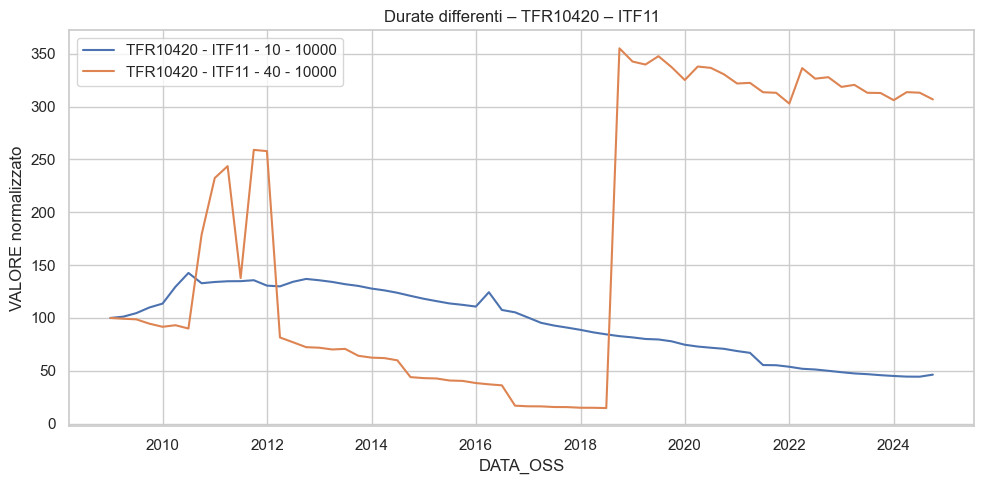

In [163]:
plot_combinazione(
    dizionario=dizionari['TFR10420'],
    chiavi=[
        ('TFR10420', 'ITF11', 10, 10000),
        ('TFR10420', 'ITF11', 40, 10000)
    ],
    normalizza=True,
    titolo="Durate differenti – TFR10420 – ITF11"
)


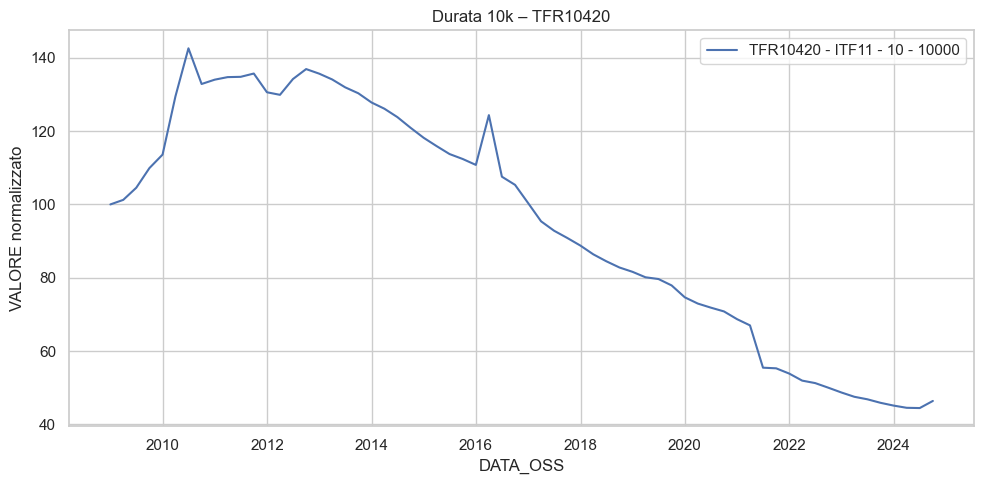

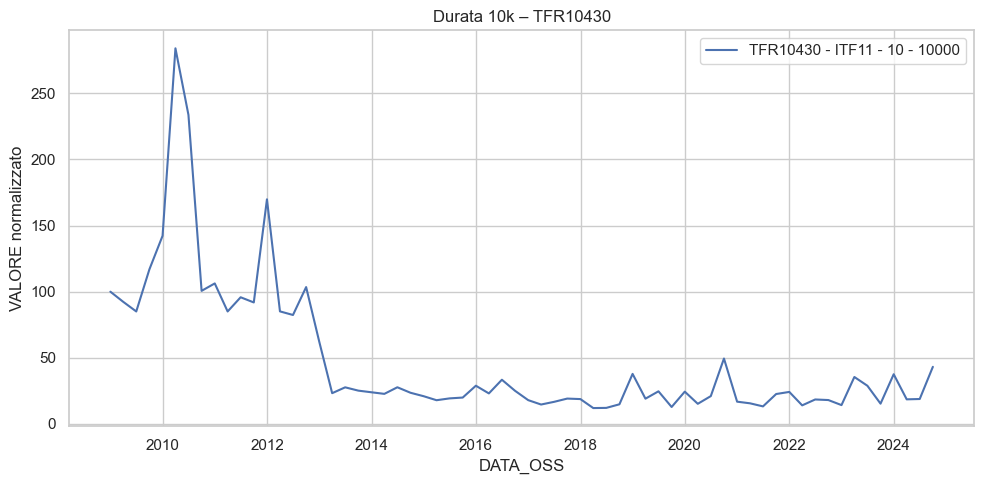

In [164]:
plot_combinazione(
    dizionario=dizionari['TFR10420'],
    chiavi=[('TFR10420', 'ITF11', 10, 10000)],
    normalizza=True,
    titolo="Durata 10k – TFR10420"
)

plot_combinazione(
    dizionario=dizionari['TFR10430'],
    chiavi=[('TFR10430', 'ITF11', 10, 10000)],
    normalizza=True,
    titolo="Durata 10k – TFR10430"
)
